_this notebook is meant to execute **`R`** in a `conda` environment_

# Introduction

This Notebook (the first-of-four) serves to introduce a user to a series of exercises focused on *higher order* **_Trend Surface analysis with R_**.

It consists of two sections:

1.   Explore the datset
2.   Deterministic Interpolation Techniques


<div class="alert alert-block alert-danger"><b>REQUIRED: </b></div>

**You are required to insert your outputs and any comment into this document.** The document you submit should therefore contain the existing text in addition to:

> *   Plots and other outputs from executing the code chunks  
> *   Discussion of your plots and other outputs as well as conclusions reached.

This should also include any hypotheses and assumptions made as well as factors that may affect your conclusions.

## 1. Explore the Dataset

_please install necessary packages through a `prompt` interface; as per the [requirements.txt](https://github.com/AdrianKriger/APG3040C-APG4013C/blob/main/cptFlatsAquifer/requirements.txt) Not here_.

In [2]:
options(prompt="> ", continue="+ ", digits=3, width=70, show.signif.stars=T, repr.plot.width=8, repr.plot.height=8)
rm(list=ls())

# Install necessary packages: You only need to run this part once
#install.packages(c("sf", "gstat", "ggplot2", "gridExtra","units", "terra","mgcv","fields","nlme"))

#library(repr)
library(sf) # 'simple features' representations of spatial objects
library(gstat) # geostatistics
#library(ggplot2) # Grammer of Graphics plots
#library(gridExtra) # arrange multiple ggplot graphics on one figure
#library(units) # units of measure
library(stars) # gridded data structures ("rasters")
#library(mgcv) # for Generalized Additive Models
#library(fields) # NCAR etc. approach to surfaces
#library(nlme) # Linear and Nonlinear Mixed Effects Models#

In [3]:
options(show.signif.stars=FALSE)

In [4]:
file = 'cptFlatsAquifer_watertable4.txt'

In [5]:
#-- import
cfaq <- read.csv(file, header = 1, sep = ',', dec = '.') #sep = '\t',

In [6]:
#-- look
head(cfaq ,3)

,name,long,lat,waterLevel,elevation,depth
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,EM_01,18.6,-34.1,14.4,20.4,63
2,EM_27,18.6,-34.1,16.2,20.0,48
3,EM_29,18.6,-34.1,18.8,25.5,39


<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- What is the purpose of producing a map of the the elevation of the top of the aquifer over the study area? In other words, who would use the map and for what purpose?

> [double click in this cell and type your answer here]

In [7]:
#names(cfaq) <- c("name", "long", "lat", "wl", "z", "d")
str(cfaq)

'data.frame':	29 obs. of  6 variables:
 $ name      : Factor w/ 29 levels "BCH_BH1","CR18_1",..: 4 15 16 9 12 8 3 2 11 20 ...
 $ long      : num  18.6 18.6 18.6 18.7 18.6 ...
 $ lat       : num  -34.1 -34.1 -34.1 -34 -34 ...
 $ waterLevel: num  14.4 16.2 18.8 20.1 22.9 ...
 $ elevation : num  20.4 20 25.5 36.5 32.7 ...
 $ depth     : num  63 48 39 45 33 33 27 27 37 26 ...


In [8]:
#- set as a spatial feature with xy coords an existing projection
cfaq.sf <- st_as_sf(cfaq, coords=c("long", "lat"), crs = 4326) #wgs84
#str(cfaq)
st_crs(cfaq.sf)

Coordinate Reference System:
  User input: EPSG:4326 
  wkt:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]

In [9]:
#- transform to local crs
cfaq.sf <- st_transform(cfaq.sf, crs = 32734) #utm 34s
cfaq.sf$X <- st_coordinates(cfaq.sf)[, "X"]
cfaq.sf$Y <- st_coordinates(cfaq.sf)[, "Y"]

In [10]:
str(st_coordinates(cfaq.sf))

 num [1:29, 1:2] 274222 276191 279770 283452 282454 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:29] "1" "2" "3" "4" ...
  ..$ : chr [1:2] "X" "Y"


In [11]:
#- summarize the coordinates
summary(st_coordinates(cfaq.sf), digits = 3)

       X                Y          
 Min.   :264519   Min.   :6227351  
 1st Qu.:272347   1st Qu.:6233265  
 Median :275582   Median :6236260  
 Mean   :275035   Mean   :6236447  
 3rd Qu.:278955   3rd Qu.:6239665  
 Max.   :283452   Max.   :6247415  

In [12]:
#save(aq, aq.sf, file="cfAquifer.rda")

In [13]:
dim(cfaq.sf)

[1] 29  7

In [14]:
#- summarize the data
summary(cfaq.sf)

      name      waterLevel      elevation         depth      
 BCH_BH1: 1   Min.   :  4.0   Min.   :  7.1   Min.   : 14.0  
 CR18_1 : 1   1st Qu.: 15.5   1st Qu.: 19.2   1st Qu.: 33.0  
 EM-14  : 1   Median : 20.1   Median : 25.5   Median : 39.0  
 EM_01  : 1   Mean   : 27.4   Mean   : 32.5   Mean   : 40.4  
 EM_08  : 1   3rd Qu.: 33.1   3rd Qu.: 34.9   3rd Qu.: 45.0  
 EM_09  : 1   Max.   :105.8   Max.   :130.0   Max.   :102.0  
 (Other):23                                                  
          geometry        X                Y          
 POINT        :29   Min.   :264519   Min.   :6227351  
 epsg:32734   : 0   1st Qu.:272347   1st Qu.:6233265  
 +proj=utm ...: 0   Median :275582   Median :6236260  
                    Mean   :275035   Mean   :6236447  
                    3rd Qu.:278955   3rd Qu.:6239665  
                    Max.   :283452   Max.   :6247415  
                                                      

In [15]:
#- bounding box
st_bbox(cfaq.sf)

   xmin    ymin    xmax    ymax 
 264519 6227351  283452 6247415 

In [16]:
#- a couple of range measurments
range(cfaq.sf$waterLevel); diff(range(cfaq.sf$waterLevel))
range(cfaq.sf$elevation); diff(range(cfaq.sf$elevation))
range(cfaq.sf$depth); diff(range(cfaq.sf$depth))

[1]   4 106

[1] 102

[1]   7.12 130.00

[1] 123

[1]  14 102

[1] 88

<div class="alert alert-block alert-warning"><b>QUESTIONS: </b> </div>

- How many observations are there? What was recorded at each point?

> [double click in this cell and type your answer here]

- What are the geographic limits of the study area? What is its area, in km2?

> [double click in this cell and type your answer here]

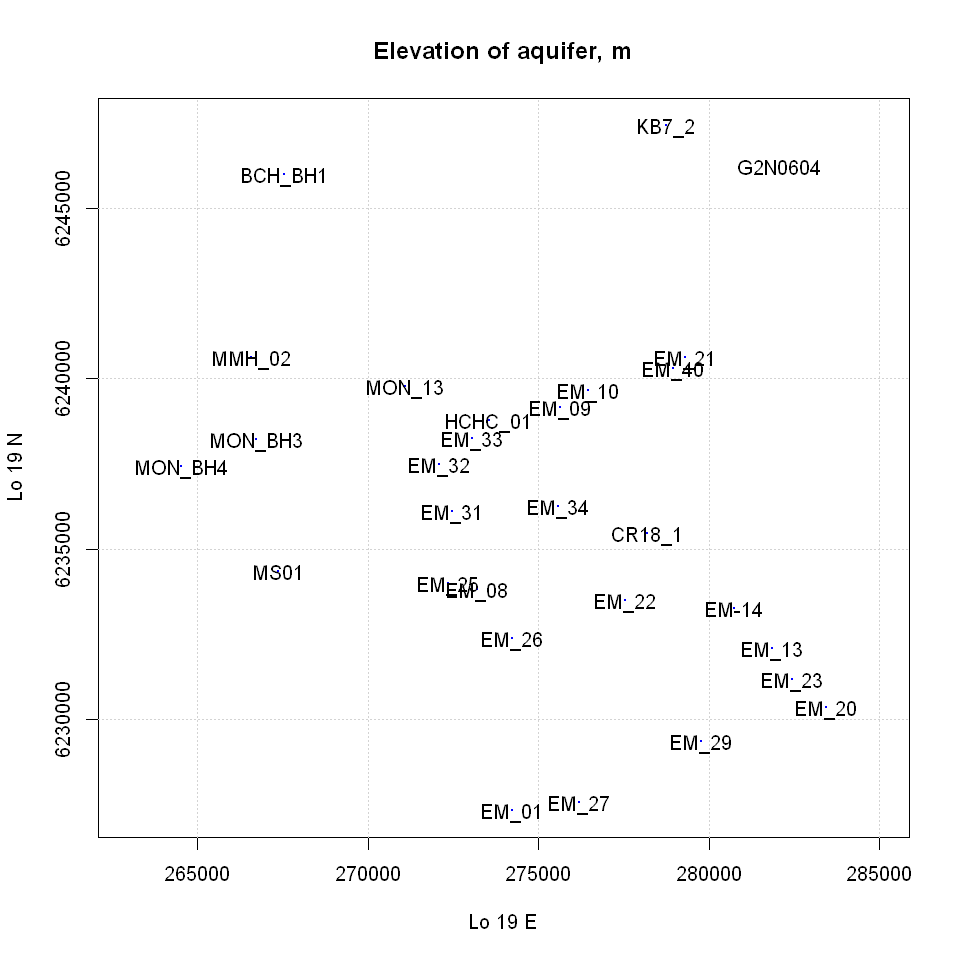

In [17]:
plot(st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
     #plot(st_coordinates(cfaq.sf)[,1] ~ st_coordinates(cfaq.sf)[,2],
     pch=20, cex=0.4, col="blue", asp=1,
     xlab="Lo 19 E", ylab="Lo 19 N")
grid()
text(st_coordinates(cfaq.sf)[,1], st_coordinates(cfaq.sf)[,2],
     #st_coordinates(cfaq.sf)[,2], st_coordinates(cfaq.sf)[,1],
     #round(cfaq$waterLevel), adj=c(0.5,0.5))
     cfaq$name, adj=c(0.5,0.5))
#text(cfaqN, round(aq$z), adj=c(0.5,0.5))
title("Elevation of aquifer, m")

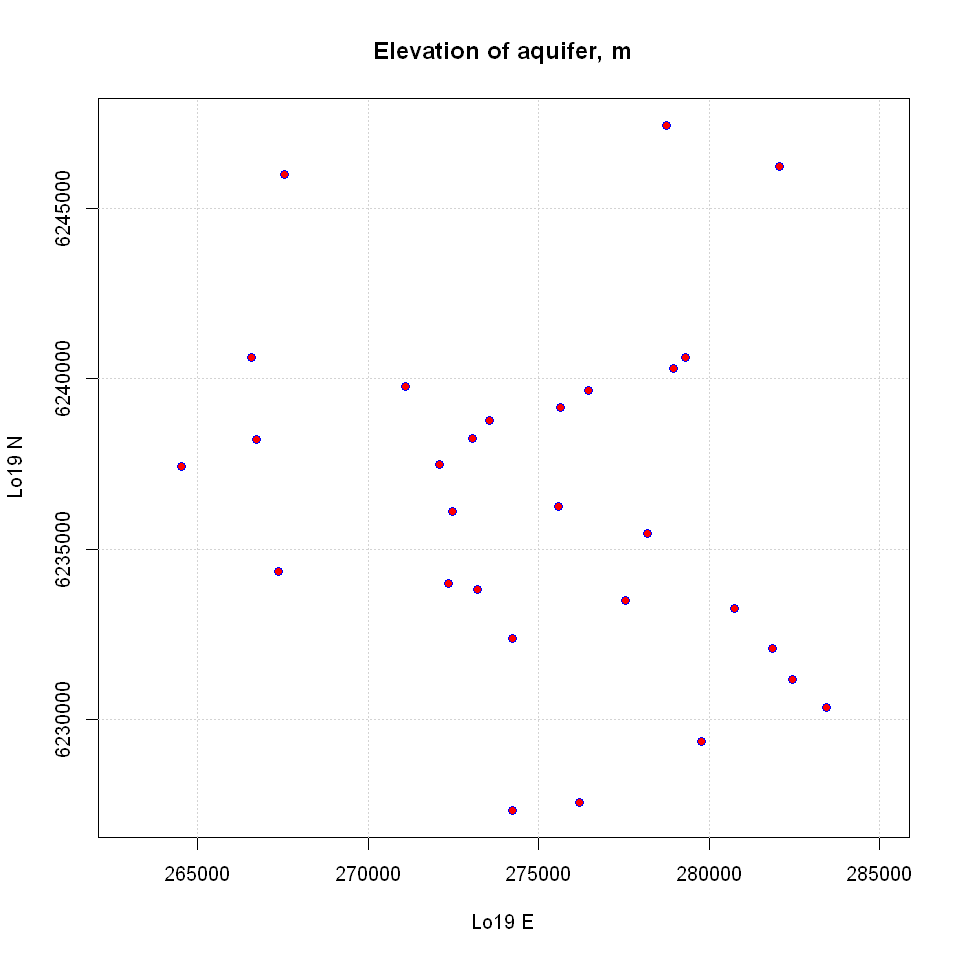

In [18]:
plot(#st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
  st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
  cex=0.8*cfaq$water_level/max(cfaq$waterLevel),
  col="blue", bg="red", pch=21, asp=1,
  xlab="Lo19 E", ylab="Lo19 N")
grid()
title("Elevation of aquifer, m")

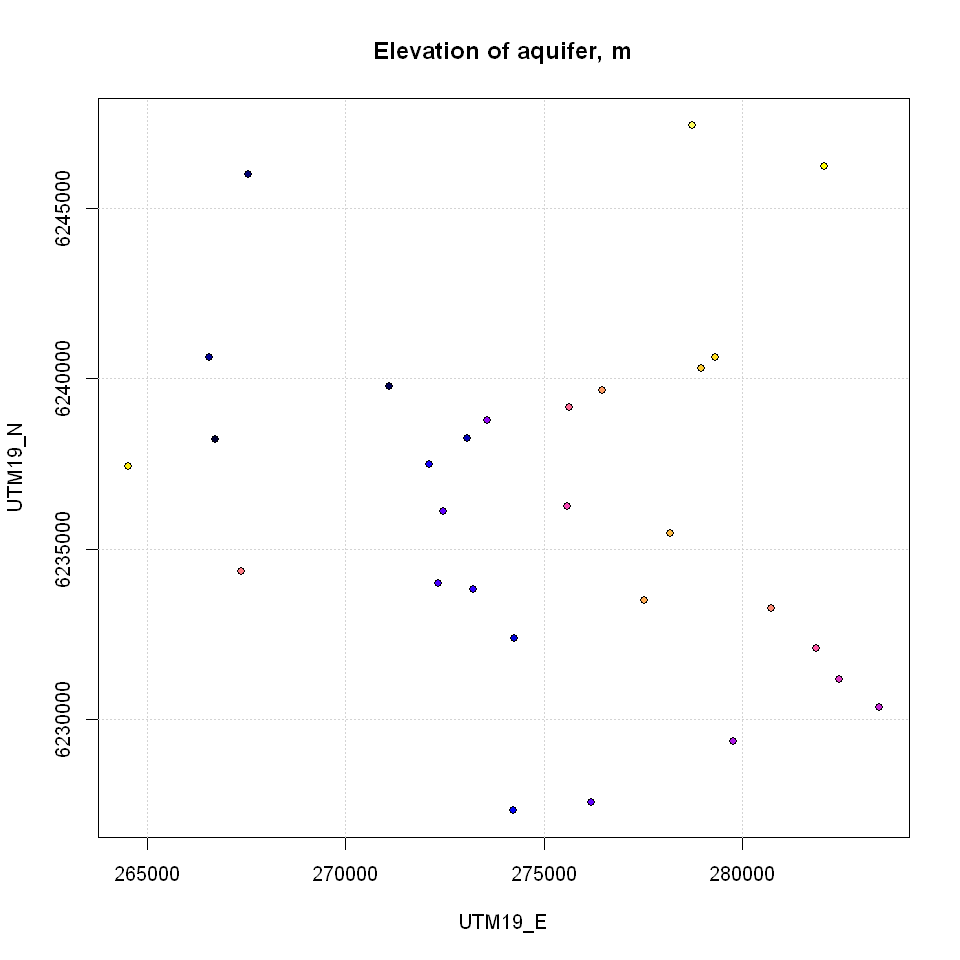

In [19]:
plot(#st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
  st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
  pch=21,
  xlab="UTM19_E", ylab="UTM19_N",
  bg=sp::bpy.colors(length(cfaq$waterLevel))[rank(cfaq$waterLevel)],
  cex=0.9)#*cfaq$waterLevel/max(cfaq$waterLevel), asp=1)
grid()
title("Elevation of aquifer, m")

<div class="alert alert-block alert-warning"><b>QUESTIONS: </b> </div>

- Describe the spatial pattern of the elevations. Do nearby points have similar values? Is there a trend across the whole area? Are there local exceptions to the trend?

> [double click in this cell and type your answer here]

# 2. Deterministic Approches to Interpolation

  Before we delve into **higher order interpolation techniques**; let us first explore two extremly useful methods we can use to model a continuous variable _(like an elevation surface or meterological observations)_.
  <ol type = "a">
    <li>Thiessen Polygons</li>
    <li>Inverse Distance Weighting (IDW)</li>
  </ol>

  _**Remember:** our goal is to estimate values where non exist. And depending on the application (and the data we have access to) higher order methods might not be necessary!_

**a. Thiessen Polygons**

  The oldest method is simply to divide the area of interest based on proximity to sample points. The result is a tesselated surface of Thiessen polygons (_also called a Voronoi Diagram_)

In [20]:
# Voronoi tesselation
pnts <- st_union(cfaq.sf)
voronoi_grid <- st_voronoi(pnts)

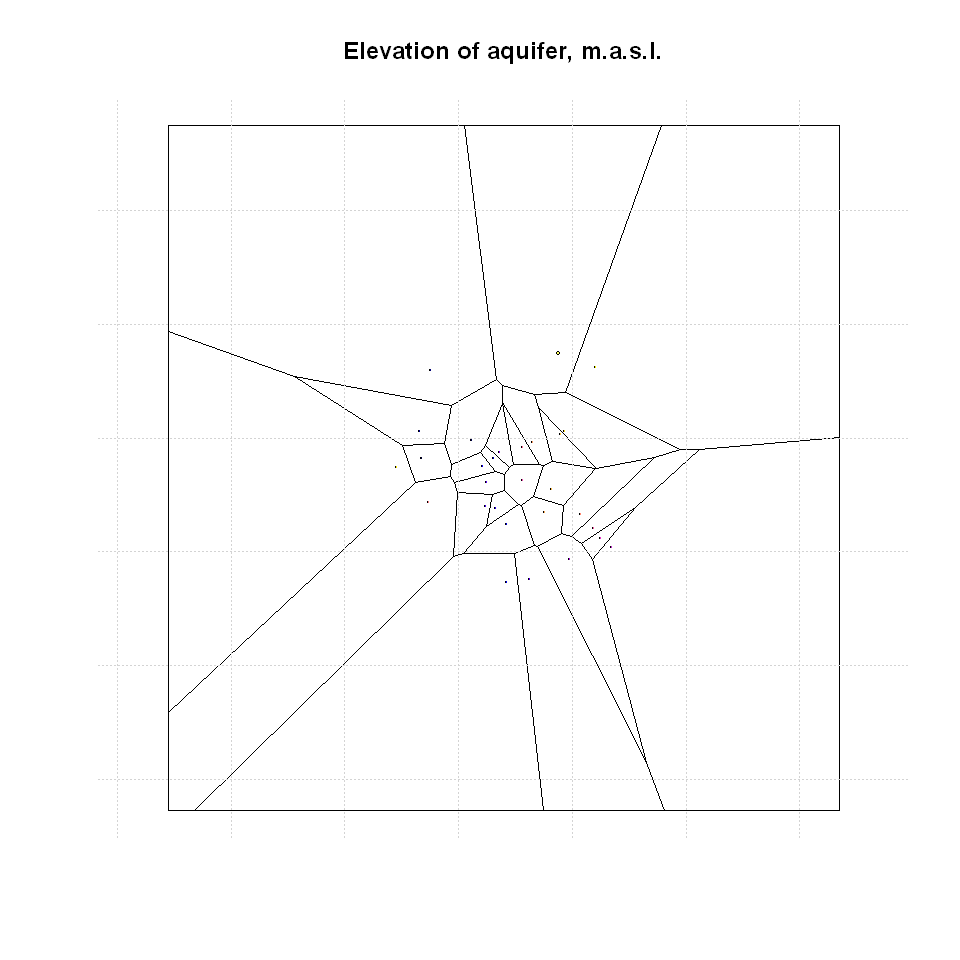

In [21]:
#-- plot
plot(voronoi_grid, col = NA)
points(st_coordinates(cfaq.sf)[,1], st_coordinates(cfaq.sf)[,2],
       pch=21,
       bg=sp::bpy.colors(length(cfaq$waterLevel))[rank(cfaq$waterLevel)],
       cex=0.4*cfaq$waterLevel/max(cfaq$waterLevel))
grid()
title("Elevation of aquifer, m.a.s.l.")

**b. IDW**

An extremely popular interpolation method calculates an average value for estimated locations using values from _nearby weighted_ locations.

In [22]:
range(st_coordinates(cfaq.sf)[,2]); range(st_coordinates(cfaq.sf)[,1])

[1] 6227351 6247415

[1] 264519 283452

**Create a 500m grid**

In [23]:
#- create grid
cfaq.bb <- st_bbox(cfaq.sf)
cfaq.bb[c("xmin","ymin")] <-   floor(cfaq.bb[c("xmin","ymin")]/1000)*1000
cfaq.bb[c("xmax","ymax")] <- ceiling(cfaq.bb[c("xmax","ymax")]/1000)*1000

#-- as a stars object
grid <- st_as_stars(cfaq.bb, dx = 500)
grid

stars object with 2 dimensions and 1 attribute
attribute(s):
    values  
 Min.   :0  
 1st Qu.:0  
 Median :0  
 Mean   :0  
 3rd Qu.:0  
 Max.   :0  
dimension(s):
  from to  offset delta     refsys point values    
x    1 40  264000   500 EPSG:32734    NA   NULL [x]
y    1 42 6248000  -500 EPSG:32734    NA   NULL [y]

In [24]:
dim(grid)

x  y 
40 42

In [25]:
summary(grid)

       Length Class  Mode   
values 1680   -none- numeric

In [26]:
st_crs(grid)$crs

NULL

In [27]:
st_bbox(grid)

   xmin    ymin    xmax    ymax 
 264000 6227000  284000 6248000 

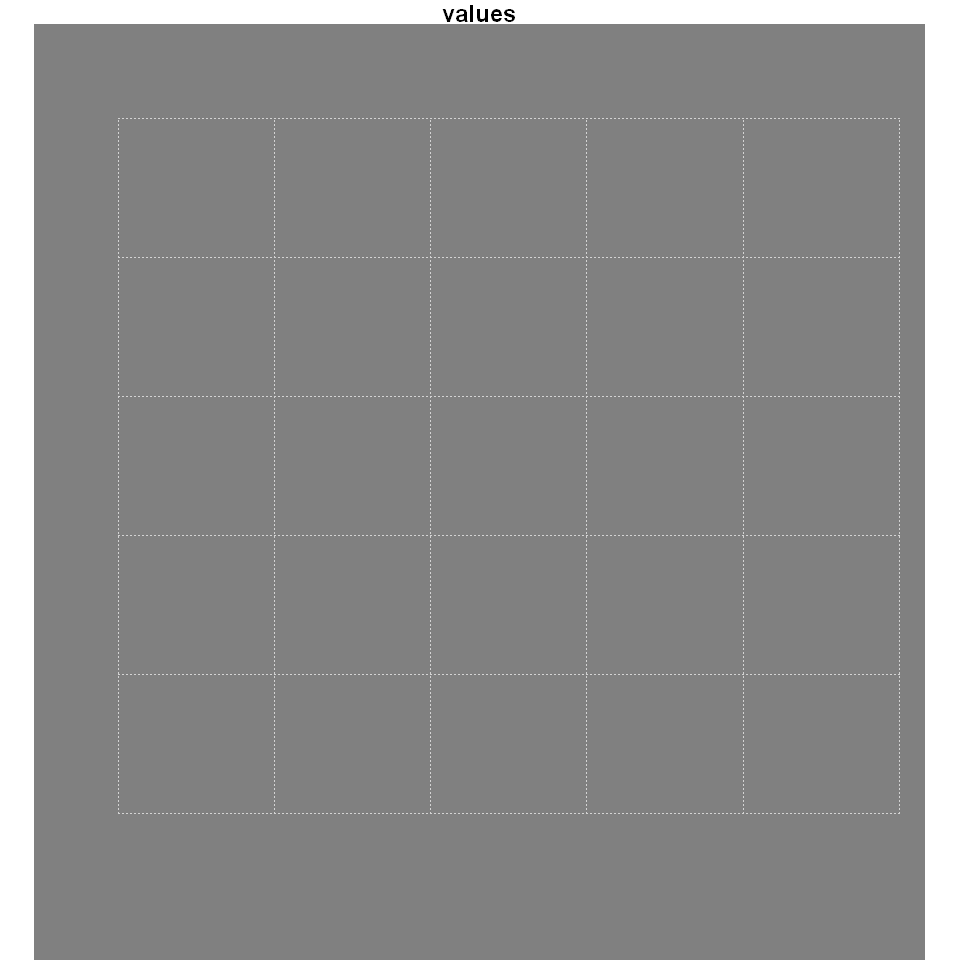

In [28]:
plot(grid); grid()

**IDW interpolation with power at 0.5, 1, 2.5 and 10** and plot the result

In [29]:
#- idw
idw_results <- list()
idp_values <- c(0.5, 1, 2.5, 10)

In [30]:
#- idw
for (idp in idp_values) {
  idw_result <- idw(log(waterLevel) ~ 1, cfaq.sf, grid, idp = idp)
  #idw <- gridkm
  #idw <- idw_result
  idw_results[[as.character(idp)]] <- idw_result
}

[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]


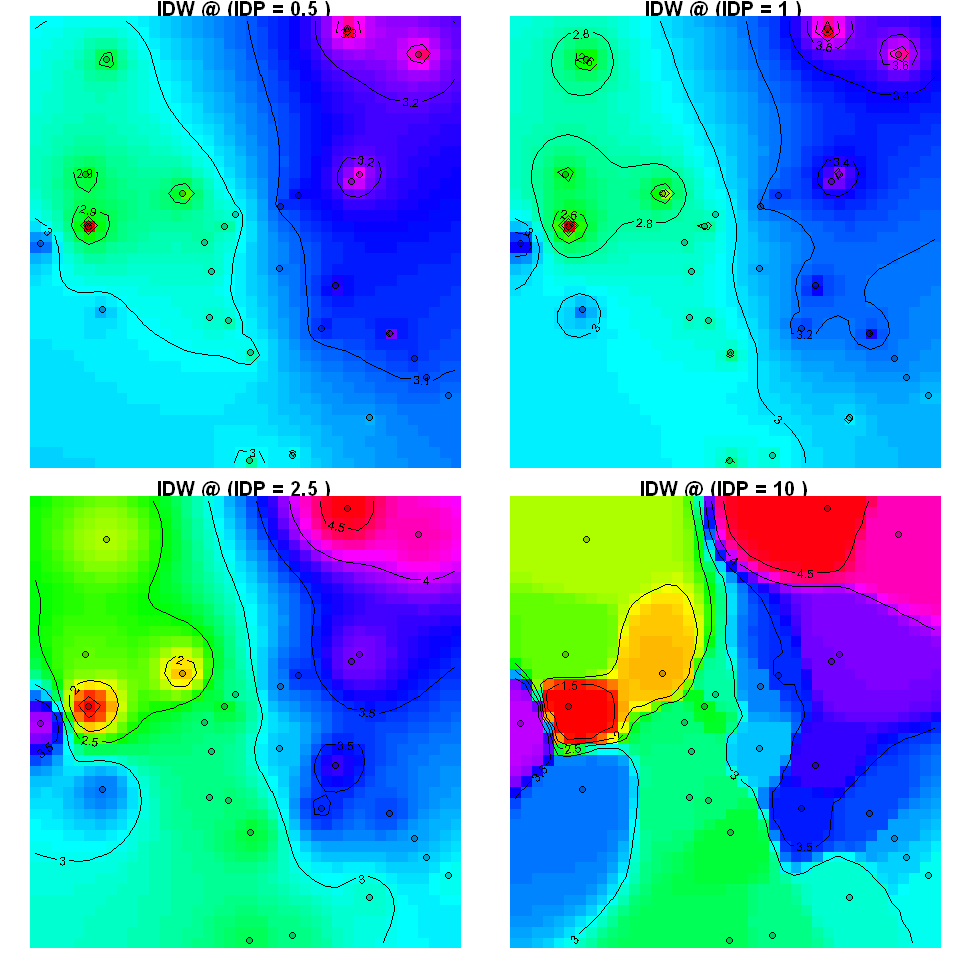

In [32]:
# Plot IDW results with overlay of original points
num_plots <- length(idp_values)
par(mfrow = c(2, 2))  # Arrange plots in 2 rows and 2 columns
# Set the size of the individual plots
plot_width <- 9
plot_height <- 9

# Set the margin and space between plots
margin_size <- 0.5
space_between_plots <- 0.3

# Calculate the total plot area
total_width <- plot_width * 2 + space_between_plots
total_height <- plot_height * 2 + space_between_plots

# Set par settings for plot layout
par(mfrow = c(2, 2), mar = c(0.6, 0.6, 0.8, 0.1),#margin_size, margin_size, margin_size, margin_size),
    oma = c(0, 0, 0, 0), mgp = c(0.5, 0.7, 0))

min.x <- floor(min(cfaq.sf$X)/1000)*1000
max.x <- ceiling(max(cfaq.sf$X)/1000)*1000

min.y <- floor(min(cfaq.sf$Y)/1000)*1000
max.y <- ceiling(max(cfaq.sf$Y)/1000)*1000

for (i in 1:num_plots) {
  idp <- idp_values[i]
  idw_result <- idw_results[[as.character(idp)]]
  title <- paste("IDW @ (IDP =", idp, ")", sep = " ")

  # Plot interpolated surface
  image(idw_result, main = title, col = rainbow(100),
        xlim = c(min.x, max.x), ylim = c(min.y, max.y),
        xlab = "", ylab = "")

  # Overlay original points
  points(cfaq.sf$X, cfaq.sf$Y, pch = 21,
         bg = adjustcolor("black", alpha.f = 0.2),
         col = "black",
         cex = 0.9, lwd = 0.5)

  contour(idw_result, add = TRUE, nlevels = 10, col = "black")
}

# Reset layout to default
par(mfrow = c(1, 1), mar = c(5.1, 4.1, 4.1, 2.1))

<div class="alert alert-block alert-warning"><b>QUESTIONS: </b> </div>

- Why do we need interpolation methods that go deeper / further than the two presented here?



> [double click in this cell and type your answer]

- Comment on the quality of the IDW

<div class="alert alert-block alert-info"><b>HINT: </b>  </div>

> Think about the subjectivity of the _power_ function and what this means. Also consider what happens when we overlay the voronoi with the various idw interpolations. What does this mean?

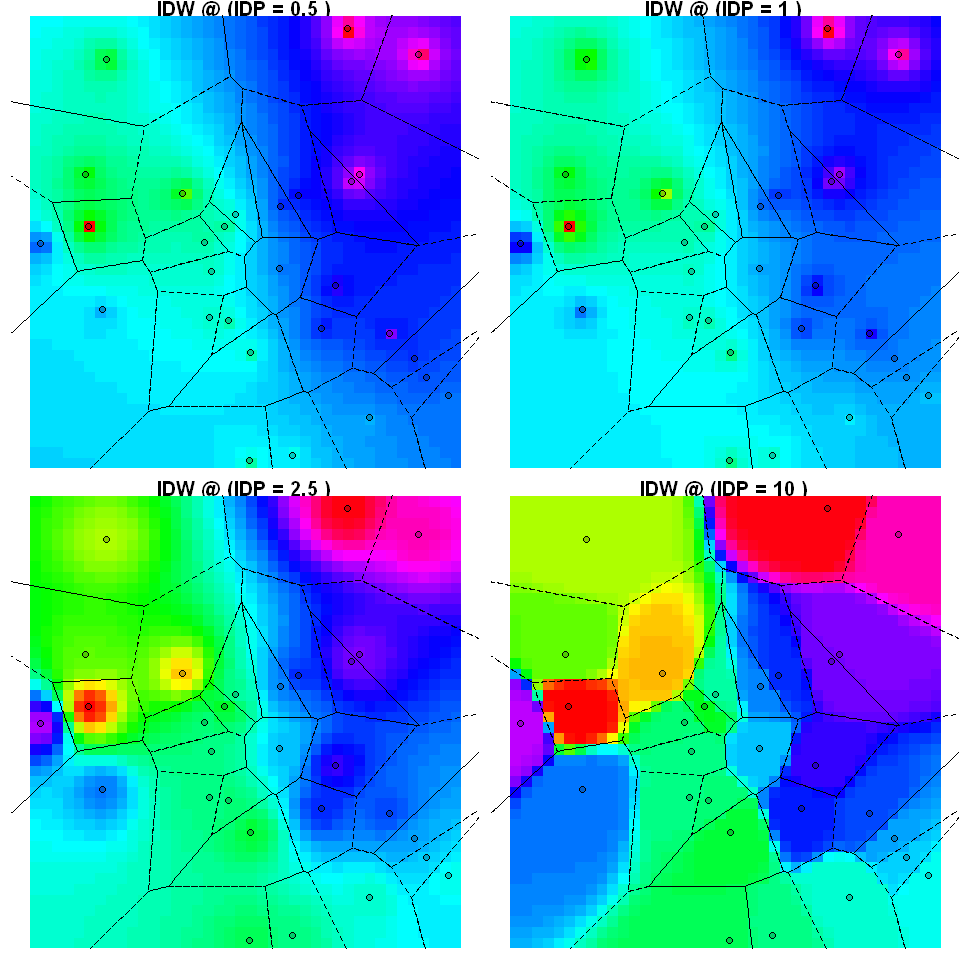

In [33]:
# Plot IDW results with overlay of original points
num_plots <- length(idp_values)
par(mfrow = c(2, 2))  # Arrange plots in 2 rows and 2 columns
# Set the size of the individual plots
plot_width <- 9
plot_height <- 9

# Set the margin and space between plots
margin_size <- 0.5
space_between_plots <- 0.3

# Calculate the total plot area
total_width <- plot_width * 2 + space_between_plots
total_height <- plot_height * 2 + space_between_plots

# Set par settings for plot layout
par(mfrow = c(2, 2), mar = c(0.6, 0.6, 0.8, 0.1),#margin_size, margin_size, margin_size, margin_size),
    oma = c(0, 0, 0, 0), mgp = c(0.5, 0.7, 0))

for (i in 1:num_plots) {
  idp <- idp_values[i]
  idw_result <- idw_results[[as.character(idp)]]
  title <- paste("IDW @ (IDP =", idp, ")", sep = " ")

  # Plot interpolated surface
  image(idw_result, main = title, col = rainbow(100),
        xlim = c(min.x, max.x), ylim = c(min.y, max.y),
        xlab = "", ylab = "")

  # Overlay Voronoi polygons
  plot(voronoi_grid, add = TRUE, border = "black", col = NA, type="l", lty=2) #lwd = 1,

  # Overlay original points
  points(cfaq.sf$X, cfaq.sf$Y, pch = 21,
         bg = adjustcolor("black", alpha.f = 0.2),
         col = "black",
         cex = 0.9, lwd = 0.5)
}

# Reset layout to default
par(mfrow = c(1, 1), mar = c(5.1, 4.1, 4.1, 2.1))

> [double click in this cell and type your answer]


- How can the quality of the IDW improve?

<div class="alert alert-block alert-info"><b>HINT: </b>  </div>

> Consider the location and density of the sample (input) points

> [double click in this cell and type your answer]